In [1]:
import itertools as it
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import toolz
import toolz.curried
from typing import Iterator, Tuple, List

# Riddler Classic
From Chris Nho comes a question of rolling (and re-rolling) a die:

You start with a fair 6-sided die and roll it six times, recording the results of each roll. You then write these numbers on the six faces of another, unlabeled fair die. For example, if your six rolls were 3, 5, 3, 6, 1 and 2, then your second die wouldn’t have a 4 on it; instead, it would have two 3s.

Next, you roll this second die six times. You take those six numbers and write them on the faces of yet another fair die, and you continue this process of generating a new die from the previous one.

Eventually, you’ll have a die with the same number on all six faces. What is the average number of rolls it will take to reach this state?

Extra credit: Instead of a standard 6-sided die, suppose you have an N-sided die, whose sides are numbered from 1 to N. What is the average number of rolls it would take until all N sides show the same number?

## Brute Force it via simulation

In [2]:
def roll(choices: List[int], n: int=6) -> List[int]:
    """Rolls a dice with numbers from choices n times and returns the results."""
    return [np.random.choice(choices) for _ in range(n)]

def unique(roll_outcome:List[int]) -> List[int]:
    """Gets the unqiue numbers from a roll of die."""
    return list(set(roll_outcome))

def simulate_once(choices: List[int], n:int) -> int:
    """Simulate 1 iteration of the game.
    Args:
      choices: The initial # of choices
      n: The number of rolls per iteration
    Returns:
      The number of iterations to complete the game.
    """
    iter = 0
    while True:
        iter += 1
        roll_outcome = roll(choices, n)
        choices = unique(roll_outcome)
        if len(choices) == 1:
            return iter
        
def simulate_many(choices: List[int], n:int, reps_per_sim:int, reps:int) -> Tuple[float, float]:
    """Solves the puzzle.
    
    Args:
     choices: The initial # of choices
     n: The number of rolls per iteration
     reps_per_sim: The number of repetitions to use to calculate expectation.
     reps: The number of times we wish to repeat the experiment.
     
    Returns:
      tuple of mean expected turns and std. error of the expected turns
    """
    exps = []
    for _ in range(reps):
        exps.append(np.mean([simulate_once(choices, n) for _ in range(reps_per_sim)]))
    return (np.mean(exps), np.std(exps) / np.sqrt(reps))

In [3]:
simulate_many(list(range(6)), 6, 250, 100)

(37.39692, 0.19038731768686695)

## Calculate it via expectations

Let us consider the case when we have 3 unique number on our die.

If we denote $E[3]$ to be the expected number of turns before we win, then we can confirm the following intuition. We need 1 roll now after which 
1. We either win with some probability or,
2. Playing a reduced game with only 2 unique numbers or,
3. Playing the game again with 3 unique numbers.

Hence,

\begin{equation*}
E[3] = 1 + p(\text{1 unique number})\times E[1] + p(\text{2 unique numbers}) \times E[2] + p(\text{3 unique numbers}) \times E[3]
\end{equation*}

Starting from $E[1] = 0$ (if there is only one number on all the faces, we stop), we can set up equations all the way up to $E[6]$ which will be our required answer.

In [4]:
def extend_sequence(choices:Iterator, sequence:Tuple) -> List[Tuple]:
    """Return all possible sequence of length L+1.
    
    Args:
      choices: The choices from which we can choose.
      sequence: The sequence to which we wish to append.
    
    Returns:
      All possible Length +1  sequences as a list
    """
    return [tuple(list(sequence) + [choice]) for choice in choices]

def all_sequences(choices:Iterator, num_slots:int) ->Iterator[Tuple]:
    """Gets all the sequences for the choices in the number of slots.
    
    Args:
     choices: The choices from which we can choose.
     num_slots: Total number of slots to fill.
     
    Returns:
      All possible choices.
    """
    enums = extend_sequence(choices, ())
    for i in range(1, num_slots):
        enums = it.chain(*[extend_sequence(choices, sequence) for sequence in enums])
    yield from enums
    
def count_ways(n_choices:int, n_rolls:int, n_unique:int) -> int:
    """"Counts the number of sequences with n_unique numbers.
    
    Args:
      n_choices: Number of choices
      n_rolls: Number of rolls (slots to fill)
      n_unique: Number of unique choices that we wish to observe.
    
    Returns:
     The number of ways we can observe those many unqiue choices.
    """
    return toolz.pipe(all_sequences(range(n_choices), n_rolls),
                      toolz.curried.filter(lambda x: len(set(x)) == n_unique),
                      set,
                      len)

def prob(n_choices:int, n_rolls:int, n_unique:int) -> float:
    """Returns the probability of the finding n_unique numbers in n_rolls with n_choices."""
    return count_ways(n_choices, n_rolls, n_unique) / (n_choices ** n_rolls)

def expectations(n_choices: int, n_rolls:int) -> float:
    exp = {}
    exp[1] = 0
    for n_choice in range(2, n_choices+1):
        denom = 1 - prob(n_choice, 6, n_choice)
        numer = 1 + sum(prob(n_choice, 6, n_unique) * exp[n_unique] for n_unique in range(1, n_choice))
        exp[n_choice] = numer / denom
    return exp[n_choices]

In [5]:
expectations(6, 6)

37.205633341552655

## Extra Credit

Text(0, 0.5, 'Expectation')

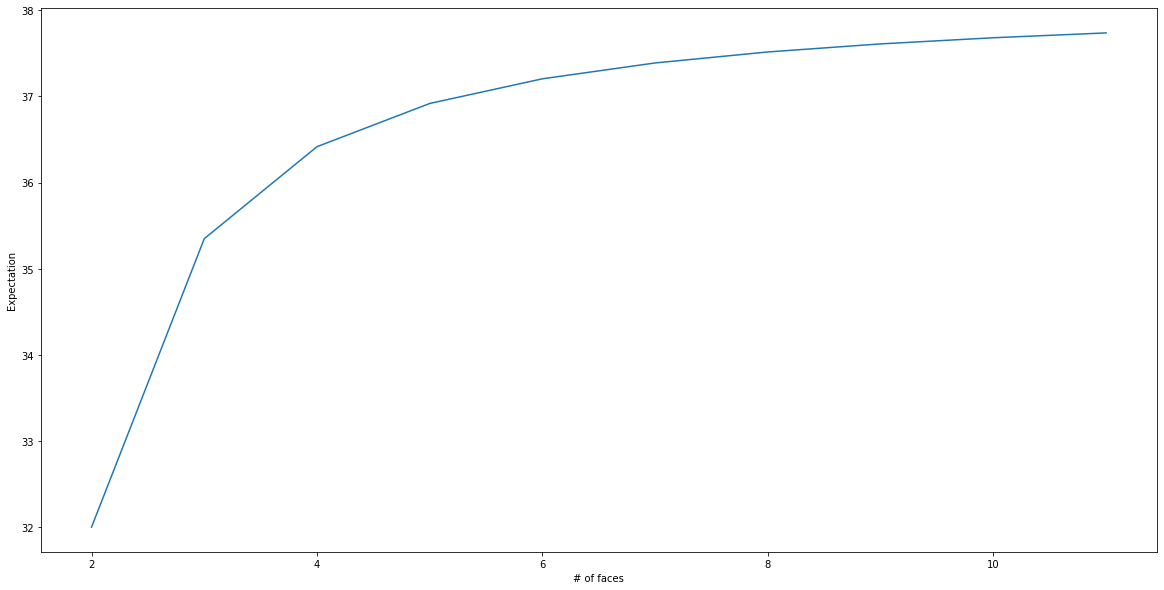

In [6]:
x = range(2, 12)
y = [expectations(n, n) for n in x]
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.set_xlabel('# of faces')
ax.set_ylabel('Expectation')

In [7]:
pd.DataFrame({'faces': z[0], 'expectation': z[1]} for z in zip(x, y))

,faces,expectation
0,2,32.000000
1,3,35.349206
2,4,36.417305
3,5,36.919038
4,6,37.205633
5,7,37.389641
6,8,37.517282
7,9,37.610807
8,10,37.682185
9,11,37.738400


# Riddler Express
These days I always have a pack of latex gloves nearby. But it’s notoriously difficult to pull exactly two gloves out of the box at a time. Sometimes I’ll pull out two gloves, other times three, and yet other times four. Somehow, I never pull out any other number of gloves at a time.

This morning, I noticed that there are 10 gloves left in the box. How many distinct ways are there for me to remove all 10 gloves from the box? Note that the order matters here — for example, pulling out two gloves, then four gloves and then another four gloves is distinct from pulling out four gloves, another four gloves and then two gloves.

## Can we enumerate all the counts

### Start with 2 picks
1. 2, 2, 2, 2, 2
2. 2, 3, 2, 3
3. 2, 3, 3, 2
4. 2, 2, 3, 3
5. 2, 4, 2, 2
6. 2, 2, 2, 4
7. 2, 2, 4, 2
8. 2, 4, 4

### Start with 3 picks
1. 3, 3, 2, 2
2. 3, 2, 3, 2
3. 3, 2, 2, 3
4. 3, 4, 3
5. 3, 3, 4

### Start with 4 picks
1. 4, 4, 2
2. 4, 2, 4
3. 4, 3, 3
4. 4, 2, 2, 2

So, we have 17 unique ways.

In [8]:
def gloves_puzzle(gloves: Tuple[int], needed: int) -> int:
    def subseq(sequence):
        return toolz.pipe(sequence,
                          it.accumulate,
                          toolz.curried.filter(lambda x: x <= needed),
                          list,
                          lambda x: range(len(x)) if x[-1] == needed else range(0),
                          toolz.curried.map(lambda i: sequence[i]),
                          tuple)
    return toolz.pipe(all_sequences(gloves, int(needed / min(gloves))),
                      toolz.curried.map(subseq),
                      set,
                      len) - 1 # empty set is also a part of the results.

In [9]:
gloves_puzzle((2, 3, 4), 10)

17